#### Welcome to the pyWWT visualization notebook!

This notebook demonstrates a PDS search API use case by visualizing Galileo Orbiter's magnetosphere measurement campaign and displays pyWWT's ability to visualize orbit data and overlay instrument data onto regions of interest.

To properly run this code, ensure that you have followed the steps outlined in the README.md file. Additionally, ensure that you have opened an "AAS Worldwide Telescope" launcher in your notebook work space. To do this simply go to File -> New Launcher and (if configured correctly) click the AAS WWT icon. See [WWTs Jupyter Application](https://pywwt.readthedocs.io/en/stable/jupyterlab.html) for troubleshooting and further setup.

# Step 0: Import Libraries

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np

import requests
import spiceypy
import os
import io

from datetime import datetime,timedelta
import matplotlib.dates as mdates
from astropy import units as u

from astropy.time import Time
from pywwt.jupyter import WWTJupyterWidget
from pywwt.jupyter import connect_to_app
from astropy.table import Table
import matplotlib.pyplot as plt


# Step 1: Function Definitions

Define functions to be used throughout the script.

There are 4 functions here:
1. **getsta:** Used to obtain the positions and velocities of Galileo relative to the J2000 date and Jupiter's coordinate frame.
2. **get_data:** This parses through and grabs the correct collections from a CSV contained in the Galileo Magnetometer [parent bundle](https://pds.nasa.gov/api/search/1/products/urn:nasa:pds:galileo-mag-jup-calibrated::1.0). This CSV contains a list of lids containing collections from each measurement period in the mission relative to 2 coordinate systems, Inertial Rotor Coordinates (IRC = despun spacecraft) and Jupiter System III(+Z spin axis, prime meridian +X axis). The IRC data files are chosen, but it doesn't matter because the plot is non-directional
3. **get_tabs:** This takes the individual collections and grabs the time and magnitude for each measurement to store into an array for later use.
4. **download_and_load_spice_kernel:** For a number of reasons we don't want SPICE kernels living on the gitHub repo, so this function installs the necessary kernels to the users local machine.

In [2]:
def getsta(mag_time):
    # METAKR = 'getgll.tm'
    # spiceypy.furnsh( METAKR )
    row = []
    for t in mag_time:
            time_string = t.strftime('%Y-%m-%d %H:%M:%S')
            # time_string = t # temporary

            #ephemeris time after iterating
            et = spiceypy.str2et( time_string )

            [state, ltime] = spiceypy.spkezr( '5', et,      'J2000',
                                            'LT+S',   '-77'       )
            row.append([state[0], state[1], state[2], state[3], state[4], state[5]])
    return row

def download_and_load_spice_kernel(p_requests_session, p_url):
    if not os.access('.spice_kernels',os.F_OK):
        os.mkdir('.spice_kernels')

    kernel_dir = os.path.join(".spice_kernels")
#     os.makedirs(kernel_dir, exist_ok=True)
    file_path = os.path.join(kernel_dir, os.path.basename(p_url))
    r = requests.get(url, allow_redirects=True)
    if r.status_code == 200:
        print('Successfully loaded:',os.path.basename(p_url))

        open(file_path, "wb").write(r.content)
    spiceypy.furnsh(file_path)


# Step 2: Load SPICE Kernels
Import the necessary SPICE Kernels and download them to on the local environment using **download_and_load_spice_kernel**.

In [3]:

KERNEL_URLS = [
    #generic LSK
    "https://naif.jpl.nasa.gov/pub/naif/pds/data/ody-m-spice-6-v1.0/odsp_1000/data/lsk/naif0008.tls",
    #CASSINI Solar System SPK 
    "https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/981005_PLTEPH-DE405S.bsp",
    #Galileo SC SPK
    "https://naif.jpl.nasa.gov/pub/naif/GLL/kernels/spk/gll_951120_021126_raj2021.bsp"
]

requests_session = requests.session()
# requests_session.mount("file://", requests.adapters.LocalFileAdapter())
for url in KERNEL_URLS:
    download_and_load_spice_kernel(requests_session, url)
    
    

Successfully loaded: naif0008.tls
Successfully loaded: 981005_PLTEPH-DE405S.bsp
Successfully loaded: gll_951120_021126_raj2021.bsp


# Get Products from Search API

Utilize the PDS registry API to grab the magnetometer data for the Galileo Orbiter.

In [4]:
#High-res data
# collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-highres-magnetosphere::1.0"
#Low-res data
collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-magspheric-survey::1.0"

url = f"https://pds.nasa.gov/api/search/1/products/{collection_lid}/members"
fields = [
    "lid",
    "vid",
    "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time",
    "pds:Target_Identification.pds:name",
    "ops:Data_File_Info.ops:file_ref",
    "pds:Field_Character.pds:name",
    "pds:Field_Character.pds:field_length"
]

#These search features do not work
start_time = "1996-11-01T00:00:00.00Z"
target_type = "Ganymede"

params = dict(
    fields=",".join(fields),
    q=f'((pds:Time_Coordinates.pds:start_date_time gt "{start_time}") and (pds:Target_Identification.pds:name eq "{target_type}"))',
    limit = 200
)


headers = dict(Accept="application/csv")
response = requests.get(
    url,
    params=params,
    headers=headers
)

# Store results in a DataFrame and print contents

In [20]:
products_csv_stream = io.StringIO(response.content.decode('utf-8'))
products_df_tot = pd.read_csv(products_csv_stream)


# change columns order
products_df_tot = products_df_tot[fields]
products_df_tot.sort_values(by = 'pds:Time_Coordinates.pds:start_date_time',inplace = True)

#User specified time range
start_time = pd.to_datetime('1996-07-19T11:00:00Z')
end_time = pd.to_datetime('1999-07-19T15:00:00Z')

# Filter the DataFrame within the time range
t_str = 'pds:Time_Coordinates.pds:start_date_time'
products_df = products_df_tot[(pd.to_datetime(products_df_tot[t_str]) >= start_time) & (pd.to_datetime(products_df_tot[t_str]) <= end_time)]

display(products_df[["lid",
    "vid",
    "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time",
    "pds:Target_Identification.pds:name",
    "ops:Data_File_Info.ops:file_ref"]])

,lid,vid,pds:Time_Coordinates.pds:start_date_time,pds:Time_Coordinates.pds:stop_date_time,pds:Target_Identification.pds:name,ops:Data_File_Info.ops:file_ref
96,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
7,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
6,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
5,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:48.392Z,1996-11-02T11:44:09.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
99,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
...,...,...,...,...,...,...
124,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1999-05-02T17:03:26.068Z,1999-06-29T07:05:56.515Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
126,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1999-06-29T07:03:39.182Z,1999-08-11T14:09:40.123Z,"[Jupiter, Callisto, Io Torus]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
23,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1999-06-29T07:03:39.182Z,1999-08-11T14:09:40.123Z,"[Jupiter, Callisto, Io Torus]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
24,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1999-06-29T07:03:39.182Z,1999-08-11T14:09:40.123Z,"[Jupiter, Callisto, Io Torus]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...


# Grab the data from the individual TAB files for the specified time range

In [21]:
col_name_str = products_df_tot['pds:Field_Character.pds:name'][0]
col_name = [item.strip() for item in col_name_str[1:-1].split(',')]

tab_urls = [tab_url for tab_url in products_df['ops:Data_File_Info.ops:file_ref'] if 'IRC' in tab_url]

col_name.insert(0,'Time')
data_tot = pd.concat((pd.read_fwf(data_file,width = 'infer',header = None,names = col_name) for data_file in tab_urls)).reset_index(drop = True)

#Put values in chronological order
data_tot.sort_values(by = 'Time',inplace = True)

print('debug')


debug


# Step 4: Obtain ephemeris for mag measurements

Obtain the position and velocity values at each magnetometer measurement timestamp using the **get_sta** function.

***Note: You can change the number of data points you would like to plot by changing the sample variable. The higher it is, the fewer data points you will plot.***

In [22]:
sample = 100

trunc_data_tot = data_tot[1::sample]
#Obtain the position data that corresponds to the measurements
print('Obtaining ephemeris for magnetometer readings...')
df = pd.DataFrame({'time':trunc_data_tot['Time'], 'data': trunc_data_tot['B-FIELD MAGNITUDE']})
df['time'] = pd.to_datetime(df['time'])
# df.sort_values('time', inplace = True)

mag_ephem_data = getsta(df['time']) #Takes time input
print("Number of magnetometer readings to plot: "+ str(len(mag_ephem_data)))


Obtaining ephemeris for magnetometer readings...
Number of magnetometer readings to plot: 17210


# Plot magnitude relative to distance

/var/folders/t7/tdt4vrqj57x7cdkbnm27lcbw0000gq/T/ipykernel_25946/3064733276.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will

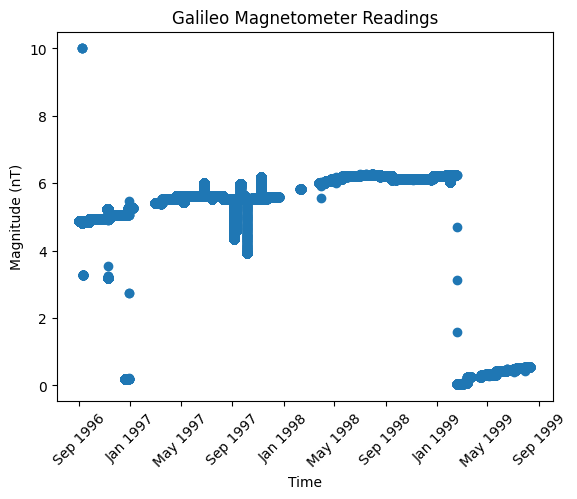

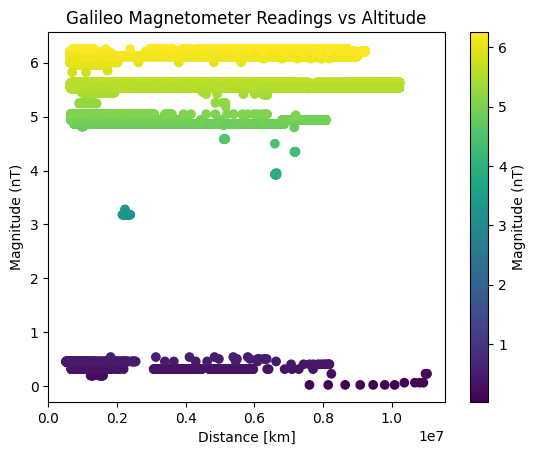

In [23]:
TimeConverted = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in data_tot['Time']]
fig, ax = plt.subplots()
cm = ax.scatter(TimeConverted,data_tot['B-FIELD MAGNITUDE'])

# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel("Time")
plt.locator_params(axis='x', nbins=10)
plt.ylabel("Magnitude (nT)")
plt.title("Galileo Magnetometer Readings")

plt.show()

fig_2, mag_d = plt.subplots()
distance = distance = np.linalg.norm(mag_ephem_data, axis=1)

cm = mag_d.scatter(distance,df['data'],c = df['data'], cmap = 'viridis' )

plt.xlabel("Distance [km]")
plt.ylabel("Magnitude (nT)")
plt.title("Galileo Magnetometer Readings vs Altitude")

cbar = plt.colorbar(cm)
cbar.set_label("Magnitude (nT)")
plt.show()

# Step 5: Obtain ephemeris for orbits

Get the ephemeris for the orbits between the first magnetometer measurement, and the last.

In [24]:
#Grab the orbit ephemeris data from the start time of the magnetometer readings to the end time.
print("Filling in ephemeris data...")
df.reset_index(inplace = True)
start_time = df['time'][0]
end_time = df['time'][len(df)-1]

ephem_time = []
ephem_time = np.arange(start_time, end_time, timedelta(hours=1)).astype(datetime)

# while ephem_time < end_time:
#     #Grab the states
# ephem_data = np.empty(len(ephem_time))
# for i in range(len(ephem_data)):
ephem_data = getsta(ephem_time)
print('Finished')


Filling in ephemeris data...
Finished


# Step 6: Organize the data for pyWWT

This step organizes all the data variables into tables for pyWWT. A table is generated for the magnetometer data and another for the ephemeris data.

In [25]:
ephem_tab = Table()
mag_tab = Table()

#Ephemeris data to table
ephem_iso = [ephem_t.replace(tzinfo=None).isoformat() for ephem_t in ephem_time]
ephem_tab['Time'] = ephem_iso

ephem_data = [row[0:3] for row in ephem_data]
transposed = zip(*ephem_data)
ephem_tab['X'], ephem_tab['Y'], ephem_tab['Z'] = transposed

#Magnetometer values and ephemeris data to table
# mag_iso = [mag_t.replace(tzinfo=None).isoformat() for mag_t in trunc_data_tot]
mag_tab['Time'] = trunc_data_tot['Time']
# mag_val = [mag_t for mag_t in df['data'][1000::]]
mag_tab['Magnitude (nT)'] = trunc_data_tot['B-FIELD MAGNITUDE']

mag_pos = [row[0:3] for row in mag_ephem_data]
mag_transpose = zip(*mag_pos)
mag_tab['X'], mag_tab['Y'], mag_tab['Z'] = mag_transpose
            
print('Done!')

Done!


# Step 7: Connect pyWWT Widget

***Before proceeding, ensure that you have another tab open in the notebook for the AAS WorldWide Telescope widget***

Instantiate the WWTJupyterWidget and await connection.

In [26]:
#Connect pyWWT widget

wwt = WWTJupyterWidget()
wwt = await connect_to_app().becomes_ready()
print('Successful Connection')
wwt.reset()

Successful Connection


# Step 8: Set view and load data

Set the WWT view to the solar system and load in the magnetometer data and ephemeris data via table layers. Once complete, in the pyWWT widget the view will be centered on Jupiter. Zoom in to see the results!

In [27]:
wwt.set_current_time(Time('1995-12-07 15:21:01.776000'))
wwt.set_view("solar system")
layer = wwt.layers.add_table_layer(table = mag_tab, frame = 'jupiter',
                                  coord_type = 'rectangular',
                                  x_att = 'X', y_att = 'Y', z_att = 'Z')
layer.xyz_unit = 'km'
layer.far_side_visible = True

layer.cmap_att = 'Magnitude (nT)'
layer.cmap.vmin = min(mag_tab['Magnitude (nT)'] + 10)
layer.cmap.vmax = max(mag_tab['Magnitude (nT)'])

layer.size_scale = 250
layer.far_side_visible = True
layer.marker_type = 'point'
layer.marker_scale = 'world'

eph = wwt.layers.add_table_layer(table = ephem_tab, frame = 'jupiter',
                                  coord_type = 'rectangular',
                                  x_att = 'X', y_att = 'Y', z_att = 'Z')
eph.xyz_unit = 'km'
eph.far_side_visible = True
eph.color = (.2, .2, .6)
eph.size_scale = 16
eph.far_side_visible = True

In [28]:
wwt.solar_system.track_object('Jupiter')


# Step 8:

Note the below code is still a work in progress and will not function as intended.

In [17]:
# start_time = ephem_tab['Time'][0]
# theta_dot = 1.76**-4 *3600 # rad/hour
# thetas = [theta_dot * (datetime.fromisoformat(start_time) - datetime.fromisoformat(curr_time)).total_seconds()/3600 for curr_time in ephem_tab['Time']]

# trans_mat = [np.array([[np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)]]) for theta in thetas]

# trans_xy = [np.dot(trans_mat,np.array([[x] , [y]])) for x,y in zip(ephem_tab['X'],ephem_tab['Y'])]

# for i in range(len(ephem_tab)):
#     trans_mat = [np.array([np.cos(thetas[i]), -np.sin(thetas[i])] , [np.sin(thetas[i]), np.cos(thetas[i])])]
#     trans_xy[i] = [np.dot(trans_mat,np.array([x] , [y])) for x,y in zip(ephem_tab['X'][i],ephem_tab['Y'])[i]]
   




In [18]:
#Animate

eph.time_series = True
eph.time_att = 'Time'
eph.time_decay = 1000000 * u.hour

# layer.time_series = True
# layer.time_att = 'Time'
# layer.time_decay = 10000 * u.hour

my_time = Time('1996-12-07 15:21:01.776000')
wwt.set_current_time(my_time)

wwt.play_time(rate=10000)

In [19]:
wwt.pause_time()